In [1]:
import numpy as np
import random
from collections import Counter

In [2]:
# Directions on 2d Lattice
DIRECTIONS = [(1, 0), (0, 1), (-1, 0), (0, -1)]

def get_neighbors(pos):
    return [(pos[0] + dx, pos[1] + dy) for dx, dy in DIRECTIONS]

def valid_moves(walk):
    last = walk[-1]
    visited = set(walk)
    return [nbr for nbr in get_neighbors(last) if nbr not in visited]

In [3]:
def initialize_walks(N):
    # Each walk starts at the origin (0, 0) and makes one ranomd step
    walks = []
    for _ in range(N):
        start = (0, 0)
        step = random.choice(DIRECTIONS)
        walks.append([start, (start[0] + step[0], start[1] + step[1])])
    return walks

def extend_walks(walks):
    new_walks = []
    weights = []
    for walk in walks:
        moves = valid_moves(walk=walk)
        k = len(moves)
        if k == 0:
            weights.append(0)
            new_walks.append(walk)
        else:
            step = random.choice(moves)
            new_walk = walk + [step]
            weights.append(k)
            new_walks.append(new_walk)
    return new_walks, weights


In [4]:
import numpy as np

TRANSFORMATIONS = np.array([
    [[0, -1], [1, 0]],     # 90° Rotation
    [[-1, 0], [0, -1]],    # 180° Rotation
    [[0, 1], [-1, 0]],     # 270° Rotation
    [[1, 0], [0, -1]],     # Reflection x-axis
    [[-1, 0], [0, 1]],     # Reflection y-axis
    [[0, 1], [1, 0]],      # Reflection x=y
    [[0, -1], [-1, 0]],    # Reflection x=-y
], dtype=np.float64)

def initialize_saws(L):
    saws = np.zeros((4, L+1, 2), dtype=np.float64)
    for i in range(L+1):
        saws[0, i] = [0, i]     # Up
        saws[1, i] = [0, -i]    # Down
        saws[2, i] = [i, 0]     # Right
        saws[3, i] = [-i, 0]    # Left
    return saws

def apply_transformation(walk, pivot_index, transformation_matrix):
    new_walk = walk.copy()
    pivot_point = walk[pivot_index]
    for i in range(pivot_index + 1, len(walk)):
        rel = walk[i] - pivot_point
        new_walk[i] = transformation_matrix @ rel + pivot_point
    return new_walk

def check_self_avoidance(walk):
    seen = set()
    for point in walk:
        key = (int(point[0]), int(point[1]))
        if key in seen:
            return False
        seen.add(key)
    return True

def monte_carlo_parallel(num_samples, L):
    saws = initialize_saws(L)
    samples = np.zeros((num_samples, L+1, 2), dtype=np.float64)

    per_chain = num_samples // 4

    for chain in range(4):
        current_walk = saws[chain].copy()
        count = 0
        index_base = chain * per_chain

        samples[index_base + count] = current_walk
        count += 1

        while count < per_chain:
            pivot = np.random.randint(1, L)
            t_idx = np.random.randint(0, len(TRANSFORMATIONS))
            T = TRANSFORMATIONS[t_idx]
            transformed_walk = apply_transformation(current_walk, pivot, T)

            if check_self_avoidance(transformed_walk):
                current_walk = transformed_walk
                samples[index_base + count] = current_walk
                count += 1

    return samples


In [5]:
def resample(walks, weights):
    total_weight = sum(weights)
    if total_weight == 0:
        raise ValueError("Walks error: all weights are zero")
    probabilities = [weight / total_weight for weight in weights]
    indices = np.random.choice(len(walks), size=len(walks), p=probabilities)
    resampled_walks = [walks[i] for i in indices]
    return resampled_walks

def smc_saw(N=1000, max_len = 20):
    walks = initialize_walks(N=N)
    logZ = 0 # log partition function, for estimating mu

    for L in range(2, max_len+ 1):
        walks, weights = extend_walks(walks=walks)
        avg_weight = np.mean(weights)
        logZ += np.log(avg_weight)
        walks = resample(walks=walks, weights=weights)
        print(f"Length {L}: avg weight = {avg_weight:.4f}")

    mu_est = np.exp(logZ / (max_len -1))
    print(f"Estimated mu: {mu_est:.4f}")
    return mu_est

In [ ]:
smc_saw(N=1000, max_len=1000)

# SMC with Pivot Algo

In [14]:
import numpy as np
from numba import njit
from collections import defaultdict
from tqdm import tqdm

# Define directions (up, down, left, right)
DIRS = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]], dtype=np.int32)

# Define transformation matrices
TRANSFORMATIONS = [
    np.array([[0, -1], [1, 0]], dtype=np.int32),    # 90° rotation
    np.array([[-1, 0], [0, -1]], dtype=np.int32),   # 180° rotation
    np.array([[0, 1], [-1, 0]], dtype=np.int32),    # 270° rotation
    np.array([[1, 0], [0, -1]], dtype=np.int32),    # Horizontal flip
    np.array([[-1, 0], [0, 1]], dtype=np.int32),    # Vertical flip
    np.array([[0, 1], [1, 0]], dtype=np.int32),     # Diagonal flip
    np.array([[0, -1], [-1, 0]], dtype=np.int32),   # Anti-diagonal flip
]

@njit
def check_self_avoidance_numba(walk):
    """Numba-accelerated self-avoidance check"""
    seen = set()
    for i in range(len(walk)):
        key = (walk[i,0], walk[i,1])
        if key in seen:
            return False
        seen.add(key)
    return True

@njit
def apply_transformation_numba(walk, pivot_idx, T):
    """Numba-compatible transformation application using dot product"""
    new_walk = walk.copy()
    pivot = walk[pivot_idx]
    for i in range(pivot_idx + 1, len(walk)):
        rel = walk[i] - pivot
        transformed = np.empty(2, dtype=np.int32)
        transformed[0] = T[0, 0] * rel[0] + T[0, 1] * rel[1]
        transformed[1] = T[1, 0] * rel[0] + T[1, 1] * rel[1]
        new_walk[i] = transformed + pivot
    return new_walk


def optimized_smc(N, max_len):
    # Initialize with pre-allocated arrays
    walks = [np.zeros((max_len, 2), dtype=np.int32) for _ in range(N)]
    for w in walks:
        w[:2] = [[0, 0], [0, 1]]  # Initial two steps
    
    logZ = 0
    avg_weights = []
    
    # Convert transformations to numpy array for numba compatibility
    TRANSFORMATIONS_np = np.array(TRANSFORMATIONS)
    
    for L in tqdm(range(2, max_len + 1), desc="Running SMC"):
        # Track active walks (non-trapped)
        active_indices = []
        weights = np.zeros(N)
        
        # Step 1: Extension
        for i in range(N):
            current = walks[i][:L]
            last_pos = current[-1]
            
            # Generate all possible moves
            neighbors = last_pos + DIRS
            valid_mask = np.ones(4, dtype=bool)
            
            # Fast collision check
            for j in range(4):
                n = neighbors[j]
                for k in range(L):
                    if n[0] == current[k,0] and n[1] == current[k,1]:
                        valid_mask[j] = False
                        break
            
            valid_count = np.sum(valid_mask)
            if valid_count > 0:
                # Choose random valid move
                valid_idx = np.where(valid_mask)[0]
                chosen = np.random.choice(valid_idx)
                walks[i][L] = neighbors[chosen]
                weights[i] = valid_count
                active_indices.append(i)
        
        # Check for complete trapping
        if len(active_indices) == 0:
            print(f"All walks trapped at L={L}, resetting")
            walks = [np.zeros((max_len + 1, 2), dtype=np.int32) for _ in range(N)]
            for w in walks:
                w[:2] = [[0, 0], [0, 1]]
            continue
        
        # Step 2: Resampling
        avg_weight = np.mean(weights[weights > 0])
        avg_weights.append(avg_weight)
        logZ += np.log(avg_weight)
        
        probs = weights / weights.sum()
        new_indices = np.random.choice(N, size=N, p=probs)
        new_walks = [walks[i].copy() for i in new_indices]
        walks = new_walks
        
        # Step 3: Pivot mutations (every 20 steps)
        if L % 20 == 0 and L > 10:
            for i in range(N):
                if np.random.rand() < 0.3:  # Only mutate 30% of walks
                    pivot_idx = np.random.randint(1, L-1)
                    T = TRANSFORMATIONS_np[np.random.randint(len(TRANSFORMATIONS_np))]
                    mutated = apply_transformation_numba(walks[i][:L+1], pivot_idx, T)
                    if check_self_avoidance_numba(mutated):
                        walks[i][:L+1] = mutated
        
        # Step 4: Diversity maintenance (every 50 steps)
        if L % 50 == 0:
            unique_walks = {}
            for w in walks:
                key = w[:L+1].tobytes()
                if key not in unique_walks:
                    unique_walks[key] = w[:L+1].copy()
            
            # If diversity is low, generate new variants
            attempts = 0
            max_attempts = 1000  # or scale with L
            while len(unique_walks) < N//2 and len(unique_walks) > 0 and attempts < max_attempts:
                for w in list(unique_walks.values()):
                    pivot_idx = np.random.randint(1, L - 1)
                    T = TRANSFORMATIONS_np[np.random.randint(len(TRANSFORMATIONS_np))]
                    mutated = apply_transformation_numba(w, pivot_idx, T)
                    if check_self_avoidance_numba(mutated):
                        unique_walks[mutated.tobytes()] = mutated
                    attempts += 1
                    if len(unique_walks) >= N//2 or attempts >= max_attempts:
                        break

            
           # Update population
            new_walks = []
            for w in unique_walks.values():
                padded = np.zeros((max_len + 1, 2), dtype=np.int32)
                padded[:L+1] = w
                new_walks.append(padded)

            # Pad to N walks
            num_missing = N - len(new_walks)
            for _ in range(num_missing):
                w = np.zeros((max_len + 1, 2), dtype=np.int32)
                w[:2] = [[0, 0], [0, 1]]
                new_walks.append(w)

            walks = new_walks  # Now walks has exactly N elements

        # Progress reporting
        if L % 100 == 0:
            unique_count = len(set(w.tobytes() for w in walks))
            print(f"L={L}: μ={np.exp(logZ/(L-1)):.4f} | Unique={unique_count}/{N}")

    return np.exp(logZ/(max_len-1)), avg_weights

Running SMC:   0%|          | 0/999 [00:00<?, ?it/s]

Running SMC:  10%|█         | 101/999 [00:06<01:15, 11.91it/s]

L=100: μ=2.7053 | Unique=560/1000


Running SMC:  20%|██        | 200/999 [00:18<01:58,  6.75it/s]

L=200: μ=2.6998 | Unique=524/1000


Running SMC:  30%|██▉       | 299/999 [00:36<02:37,  4.43it/s]

L=300: μ=2.6985 | Unique=512/1000


Running SMC:  40%|███▉      | 399/999 [01:02<02:51,  3.49it/s]

L=400: μ=2.6984 | Unique=509/1000


Running SMC:  50%|████▉     | 499/999 [01:35<03:03,  2.73it/s]

L=500: μ=2.6982 | Unique=505/1000


Running SMC:  60%|█████▉    | 599/999 [02:17<03:02,  2.19it/s]

L=600: μ=2.6983 | Unique=527/1000


Running SMC:  70%|██████▉   | 699/999 [03:06<02:42,  1.85it/s]

L=700: μ=2.6982 | Unique=488/1000


Running SMC:  80%|███████▉  | 799/999 [04:02<01:59,  1.67it/s]

L=800: μ=2.6968 | Unique=524/1000


Running SMC:  90%|████████▉ | 899/999 [05:06<01:05,  1.52it/s]

L=900: μ=2.6975 | Unique=508/1000


Running SMC: 100%|██████████| 999/999 [06:16<00:00,  2.65it/s]

L=1000: μ=2.6976 | Unique=515/1000


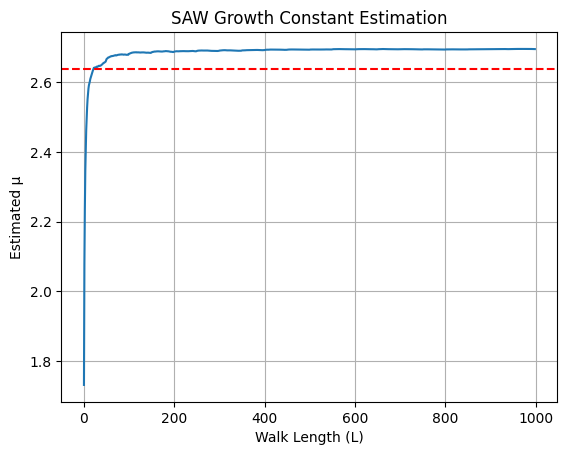

In [15]:
import matplotlib.pyplot as plt

# Run with N=1000, max_len=1000
mu_est, avg_weights = optimized_smc(N=1000, max_len=1000)

# Plot results
import matplotlib.pyplot as plt
plt.plot(np.exp(np.cumsum(np.log(avg_weights)) / np.arange(2, len(avg_weights)+2)))
plt.axhline(y=2.638, color='r', linestyle='--')
plt.xlabel('Walk Length (L)')
plt.ylabel('Estimated μ')
plt.title('SAW Growth Constant Estimation')
plt.grid(True)
plt.show()